<a href="https://colab.research.google.com/github/Rio-HEPLab/ML4Physics/blob/PPGF-2025-1/15-Denoising-AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto-encoder para remoção de ruído (*denoising*)

<img src="https://raw.githubusercontent.com/Rio-HEPLab/ML4Physics/PPGF-2025-1/pics/AE-Denoising.png" width=500>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import keras

from keras.models import Model
from keras.datasets import mnist
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Input, UpSampling2D

In [3]:
(X_train, _), (X_test, _) = mnist.load_data()
X_valid, X_train = X_train[:10000], X_train[10000:]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# normalize train data
X_train = X_train.astype('float32') / 255.
X_valid = X_valid.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
X_valid = np.reshape(X_valid, (len(X_valid), 28, 28, 1))
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


### Adicionando ***ruido*** nas imagens.


In [5]:
# create noisy data
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_valid_noisy = X_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_valid.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

In [7]:
# renormalize through clipping
# o clipping vai cortar o "excedente" do ruido nos extremos para voltar a ficar na escala escolhida
X_train_noisy = np.clip( X_train_noisy, 0., 1. )
X_valid_noisy = np.clip( X_valid_noisy, 0., 1. )
X_test_noisy = np.clip( X_test_noisy, 0., 1. )

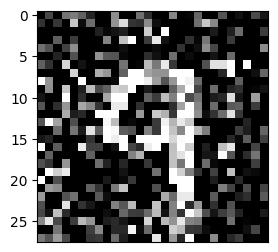

In [10]:
i=np.random.randint(0,9999)

fig = plt.figure( figsize=(3,3) )
plt.imshow( X_test_noisy[i].reshape(28,28) )
plt.gray()
plt.gca().get_xaxis().set_visible(False)

In [11]:
# create the encode network
input_img = Input(shape=(28,28,1))
x = Convolution2D(32,(3,3),activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2),padding='same')(x)
x = Convolution2D(32,(3,3),activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)
# 7,7,32

In [12]:
# create the decode network
x = Convolution2D(32,(3,3),activation='relu',padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Convolution2D(32,(3,3),activation='relu',padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Convolution2D(1,(3,3),activation='sigmoid',padding='same')(x)
#back to 28,28,1

In [13]:
# create the autoencoder by tying the encode and decode networks together
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training
epochs=20
batch_size=256
autoencoder.fit(
  X_train_noisy, X_train,
  epochs=epochs,
  batch_size=batch_size,
  shuffle=True,
  validation_data=( X_valid_noisy, X_valid ) )

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 108s 551ms/step - loss: 0.1231 - val_loss: 0.1175
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 111s 566ms/step - loss: 0.1169 - val_loss: 0.1146
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 143s 571ms/step - loss: 0.1136 - val_loss: 0.1113
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 136s 539ms/step - loss: 0.1113 - val_loss: 0.1093
Epoch 5/10
 26/196 ━━━━━━━━━━━━━━━━━━━━ 1:26 507ms/step - loss: 0.1083

In [ ]:
# Encoder model
encoder = Model(input_img, encoded)
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,568 (37.38 KB)

 Trainable params: 9,568 (37.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Decoder model
encoded_input = Input(shape=(7,7,32))

def dodecoder( X, list_layers, nlayers ):
  layer_seq = list_layers[-nlayers:]
  decoded_input = X
  for decoder_ in layer_seq:
      decoded_input = decoder_(decoded_input)
  return decoded_input

# this is pretty ugly.  there is a better way ABOVE!
# decoder1 = autoencoder.layers[-5]
# decoder2 = autoencoder.layers[-4]
# decoder3 = autoencoder.layers[-3]
# decoder4 = autoencoder.layers[-2]
# decoder5 = autoencoder.layers[-1]
# decoder = Model(encoded_input, decoder5(decoder4(decoder3(decoder2(decoder1(encoded_input))))))
# decoder.summary()

a=dodecoder(encoded_input,autoencoder.layers,5)
decoder=Model(encoded_input,a)
decoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,785 (73.38 KB)

 Trainable params: 18,785 (73.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# run noisy test data through the encoder
encoded_imgs = encoder.predict( X_test_noisy )

# run encoded noisy test image back through the decoder
decoded_imgs = decoder.predict( encoded_imgs )

# make sense of the shapes
print(encoded_imgs.shape)
print(decoded_imgs.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(10000, 7, 7, 32)
(10000, 28, 28, 1)


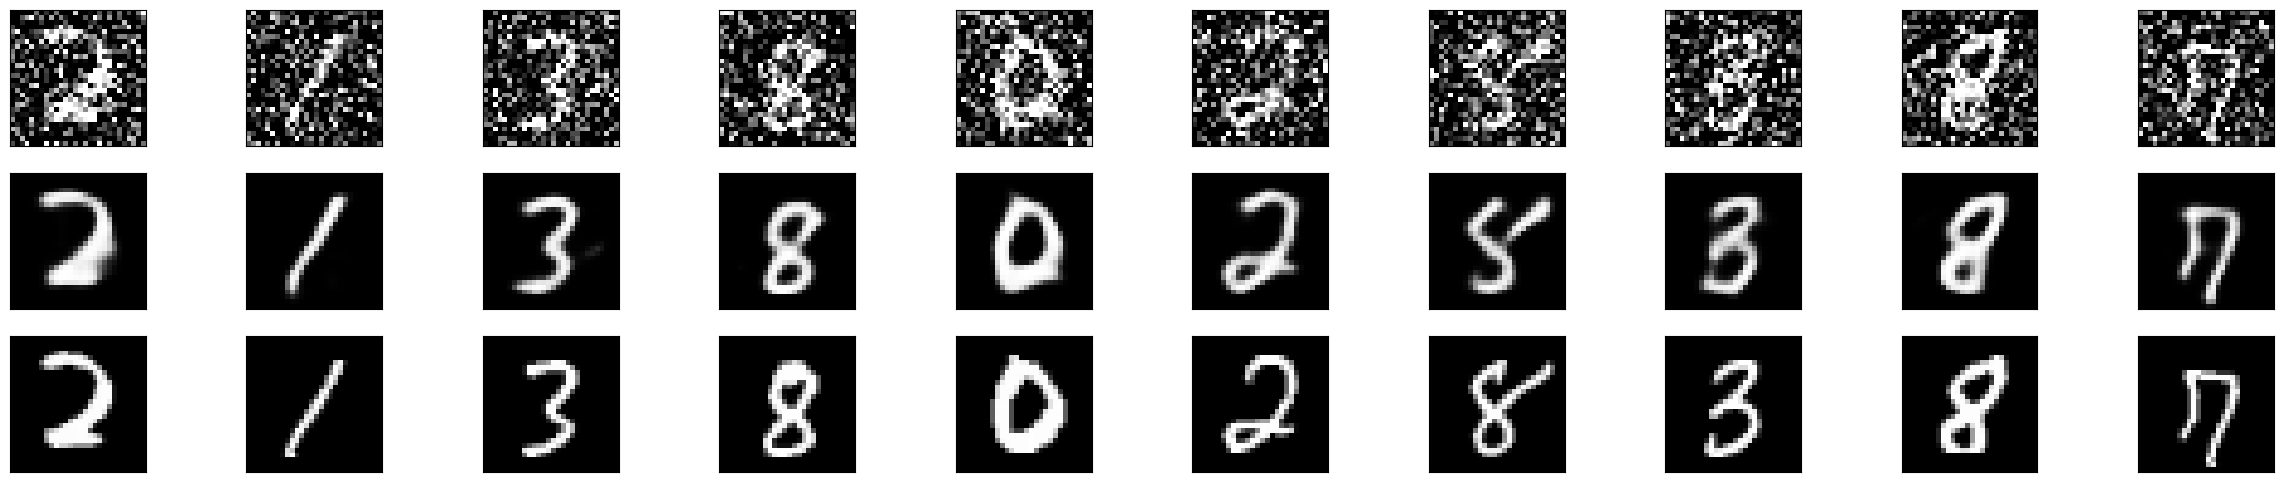

In [ ]:
# display n random images
n = 9
indxs = np.random.randint( 0, 10000, n )

## achei um digito bem ambiguo que o algoritmo de denoising reconstruiu diferente
## se o ruido subir para 0.7, vou salvar para ver como se comporta com outros niveis de ruido
## com noise_factor <= 0.6 consegue voltar ao original
indxs = np.append(indxs,1494)
n=n+1

plt.figure(figsize=(30,6))
for j,i in enumerate(indxs):

  # noisy images
  ax = plt.subplot(3,n,j+1)
  plt.imshow( X_test_noisy[i].reshape(28,28) )
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # denoised images
  ax = plt.subplot(3,n,j+1+n)
  plt.imshow( decoded_imgs[i].reshape(28,28) )
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # original images
  ax = plt.subplot(3,n,j+1+n*2)
  plt.imshow( X_test[i].reshape(28,28) )
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### Exercício:
   * Tente mudar o fator de ruido para valores maiores e retreinar o algoritmo. São observadas diferenças?
   * O que acontece se aumentar o ruido apenas no dataset de teste e aplicar o modelo que foi treinado com ruido moderado (~0.5) nas imagens com ruido alto?

In [ ]:
new_noise = 0.9
X_test_supernoisy  = X_test + new_noise * np.random.normal( loc=0.0, scale=1.0, size=X_test.shape )

In [ ]:
# run noisy test data through the encoder
encoded_imgs_sn = encoder.predict(X_test_supernoisy)

# run encoded noisy test image back through the decoder
decoded_imgs_sn = decoder.predict(encoded_imgs_sn)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


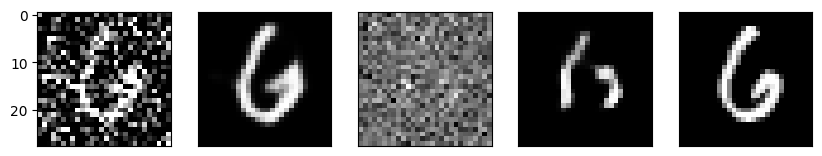

In [ ]:
plt.figure(figsize=(10,6))
i=np.random.randint(0,9999)
# i=1494

# noisy images for training
ax = plt.subplot(1,5,1)
plt.imshow(X_test_noisy[i].reshape(28,28))
plt.gray()
ax.get_xaxis().set_visible(False)

# denoised images
ax = plt.subplot(1,5,2)
plt.imshow(decoded_imgs[i].reshape(28,28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


#super noisy images for test
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1,5,3)
plt.imshow(X_test_supernoisy[i].reshape(28,28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# denoised images
ax = plt.subplot(1,5,4)
plt.imshow(decoded_imgs_sn[i].reshape(28,28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# original images
ax = plt.subplot(1,5,5)
plt.imshow(X_test[i].reshape(28,28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

### Exercício: Crie dados correspondendo a uma distribuição de probabilidades multi-dimensional. Adicione ruído a essa distribuição e construa um AE para remoção do ruído do conjunto de dados.